# https://towardsdatascience.com/trading-strategy-technical-analysis-with-python-ta-lib-3ce9d6ce5614
In this post, I will build a strategy with RSI (a momentum indicator) and Bollinger Bands %b (a volatility indicator). High RSI (usually above 70) may indicate a stock is overbought, therefore it is a sell signal. Low RSI (usually below 30) indicates stock is oversold, which means a buy signal. Bollinger Bands tell us most of price action between the two bands. Therefore, if %b is above 1, price will likely go down back within the bands. Hence, it is a sell signal. While if it is lower than 0, it is considered a buy signal. The strategy is a simple voting mechanism. When two indicators think it is time to buy, then it issues buy order to enter. When both indicators think it is time to sell, then it issues sell order to exit.

In [3]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from talib import RSI, BBANDS
import matplotlib.pyplot as plt
start = '2015-04-22'
end = '2017-04-22'

symbol = 'MCD'
max_holding = 100
price = web.DataReader(name=symbol, data_source='yahoo', start=start, end=end)

In [4]:
price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-04-21,96.550003,94.540001,96.190002,94.870003,5981700.0,79.466454
2015-04-22,99.349998,96.239998,97.000000,97.839996,19254300.0,81.954208
2015-04-23,97.519997,96.559998,97.440002,97.000000,6336500.0,81.250587
2015-04-24,99.080002,96.839996,96.989998,98.739998,7741300.0,82.708092
2015-04-27,98.940002,96.260002,98.739998,96.440002,7282700.0,80.781532
...,...,...,...,...,...,...
2017-04-17,131.869995,130.910004,131.250000,131.350006,3236400.0,117.169243
2017-04-18,132.800003,131.800003,132.009995,132.300003,3617400.0,118.016632
2017-04-19,133.000000,132.339996,132.639999,132.639999,3132800.0,118.319946


In [5]:
price = price.iloc[::-1]
price = price.dropna()
close = price['Adj Close'].values
up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
rsi = RSI(close, timeperiod=14)
print("RSI (first 10 elements)\n", rsi[14:24])

RSI (first 10 elements)
 [20.03162085 19.09117153 17.61686812 25.49149936 25.99105791 25.30588608
 23.77586531 25.20836891 22.56058945 26.29750938]


In [9]:
#Convert Bollinger Bands to %b

def bbp(price):
    up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    bbp = (price['Adj Close'] - low) / (up - low)
    return bbp

In [13]:
#Compute the holdings based on the indicators
holdings = pd.DataFrame(index=price.index, data={'Holdings': np.array([np.nan] * price.index.shape[0])})
holdings.loc[((price['RSI'] < 30) & (price['BBP'] < 0)), 'Holdings'] = max_holding
holdings.loc[((price['RSI'] > 70) & (price['BBP'] > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

KeyError: 'RSI'

In [11]:
#Further, we should get the trading action based on the holdings
holdings['Order'] = holdings.diff()
holdings.dropna(inplace=True)

NameError: name 'holdings' is not defined

NameError: name 'index' is not defined

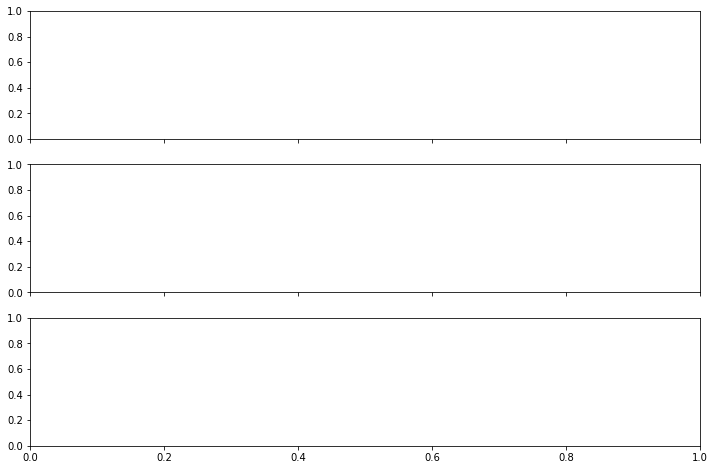

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
ax0.plot(index, price['AdjClose'], label='AdjClose')
ax0.set_xlabel('Date')
ax0.set_ylabel('AdjClose')
ax0.grid()
for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=price.loc[day, 'AdjClose'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=price.loc[day, 'AdjClose'], color='red')

ax1.plot(index, price['RSI'], label='RSI')
ax1.fill_between(index, y1=30, y2=70, color='#adccff', alpha='0.3')
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

ax2.plot(index, price['BB_up'], label='BB_up')
ax2.plot(index, price['AdjClose'], label='AdjClose')
ax2.plot(index, price['BB_low'], label='BB_low')
ax2.fill_between(index, y1=price['BB_low'], y2=price['BB_up'], color='#adccff', alpha='0.3')
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()

fig.tight_layout()
plt.show()